# Analyse de la démission chez TechNova

## Contexte du projet
TechNova fait face à un taux de démission élevé. L'objectif de ce projet est d'identifier les causes potentielles de démission à travers l'analyse de données provenant de trois sources :
- Système SIRH (informations sur les employés)
- Système d'évaluation de performance
- Sondage annuel employés

## Objectifs
1. Analyser les différences entre employés démissionnaires et non-démissionnaires
2. Créer un modèle de classification pour prédire les démissions
3. Identifier les facteurs de risque principaux

## 1. Configuration de l'environnement et imports

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, precision_recall_curve, 
                           roc_auc_score, accuracy_score, precision_score, recall_score, f1_score)
from sklearn.inspection import permutation_importance

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_palette("husl")

print("Librairies importées avec succès")

Librairies importées avec succès


## 2. Chargement et exploration des fichiers de données

In [23]:
sirh_df = pd.read_csv('extrait_sirh.csv')
eval_df = pd.read_csv('extrait_eval.csv')
sondage_df = pd.read_csv('extrait_sondage.csv')

print("=== INFORMATION SUR LES FICHIERS ===")
print(f"SIRH: {sirh_df.shape[0]} lignes, {sirh_df.shape[1]} colonnes")
print(f"Evaluations: {eval_df.shape[0]} lignes, {eval_df.shape[1]} colonnes")
print(f"Sondage: {sondage_df.shape[0]} lignes, {sondage_df.shape[1]} colonnes")

=== INFORMATION SUR LES FICHIERS ===
SIRH: 1470 lignes, 12 colonnes
Evaluations: 1470 lignes, 10 colonnes
Sondage: 1470 lignes, 12 colonnes


In [24]:
print("=== STRUCTURE DU FICHIER SIRH ===")
print(sirh_df.head())
print(f"\nColonnes: {list(sirh_df.columns)}")
print(f"Types: \n{sirh_df.dtypes}")

print("\n=== STRUCTURE DU FICHIER EVALUATIONS ===")
print(eval_df.head())
print(f"\nColonnes: {list(eval_df.columns)}")

print("\n=== STRUCTURE DU FICHIER SONDAGE ===")
print(sondage_df.head())
print(f"\nColonnes: {list(sondage_df.columns)}")
print(f"\nRépartition des démissions:")
print(sondage_df['a_quitte_l_entreprise'].value_counts())

=== STRUCTURE DU FICHIER SIRH ===
   id_employee  age genre  revenu_mensuel statut_marital departement  \
0            1   41     F            5993    Célibataire  Commercial   
1            2   49     M            5130       Marié(e)  Consulting   
2            4   37     M            2090    Célibataire  Consulting   
3            5   33     F            2909       Marié(e)  Consulting   
4            7   27     M            3468       Marié(e)  Consulting   

                    poste  nombre_experiences_precedentes  \
0        Cadre Commercial                               8   
1  Assistant de Direction                               1   
2              Consultant                               6   
3  Assistant de Direction                               1   
4              Consultant                               9   

   nombre_heures_travailless  annee_experience_totale  \
0                         80                        8   
1                         80                       1

## 3. Nettoyage et préparation des données

In [25]:
# Nettoyage de la colonne d'augmentation de salaire (retirer le % et convertir en float)
eval_df['augementation_salaire_precedente'] = eval_df['augementation_salaire_precedente'] \
    .str.replace('%', '', regex=False).astype(float)

# Création de la variable cible de démission
sondage_df['demission'] = (sondage_df['a_quitte_l_entreprise'] == 'Oui').astype(int)

# ====== Étape 2 : Diagnostic initial ======
print("\n=== VERIFICATION DU NETTOYAGE INITIAL ===")
print("Valeurs manquantes SIRH:", sirh_df.isna().sum().sum())
print("Valeurs manquantes Évaluations:", eval_df.isna().sum().sum())
print("Valeurs manquantes Sondage:", sondage_df.isna().sum().sum())
print("Répartition de la variable cible :\n", sondage_df['demission'].value_counts())

# ====== Étape 3 : Vérification et suppression des doublons ======
def remove_duplicates(df, df_name):
    if 'id_employee' in df.columns:
        dup_count = df.duplicated(subset='id_employee').sum()
        print(f"Doublons {df_name} (id_employee) : {dup_count}")
        if dup_count > 0:
            df.drop_duplicates(subset='id_employee', inplace=True)
            print(f"   -> {dup_count} doublon(s) supprimé(s) dans {df_name}")
    return df

print("\n=== CONTRÔLE DES DOUBLONS ===")
sirh_clean = remove_duplicates(sirh_df.copy(), 'SIRH')
eval_clean = remove_duplicates(eval_df.copy(), 'Évaluations')
sondage_clean = remove_duplicates(sondage_df.copy(), 'Sondage')

# ====== Étape 4 : Imputation des valeurs manquantes ======
def impute_missing_values(df):
    for col in df.columns:
        if df[col].dtype.kind in 'biufc':
            # Colonne numérique => remplacer les NaN par la médiane
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
        else:
            # Colonne catégorielle => remplacer les NaN par la modalité la plus fréquente
            mode_series = df[col].mode()
            if not mode_series.empty:
                mode_val = mode_series[0]
                df[col] = df[col].fillna(mode_val)
            else:
                # Si aucun mode, remplir avec chaîne vide ou valeur sentinelle
                df[col] = df[col].fillna("Inconnu")
    return df

sirh_clean = impute_missing_values(sirh_clean)
eval_clean = impute_missing_values(eval_clean)
sondage_clean = impute_missing_values(sondage_clean)

print("\n=== VALEURS MANQUANTES CORRIGÉES ===")
print("SIRH :", sirh_clean.isnull().sum().sum())
print("Évaluations :", eval_clean.isnull().sum().sum())
print("Sondage :", sondage_clean.isnull().sum().sum())


=== VERIFICATION DU NETTOYAGE INITIAL ===
Valeurs manquantes SIRH: 0
Valeurs manquantes Évaluations: 0
Valeurs manquantes Sondage: 0
Répartition de la variable cible :
 demission
0    1233
1     237
Name: count, dtype: int64

=== CONTRÔLE DES DOUBLONS ===
Doublons SIRH (id_employee) : 0

=== VALEURS MANQUANTES CORRIGÉES ===
SIRH : 0
Évaluations : 0
Sondage : 0


## 4. Fusion des jeux de données en DataFrame central

In [26]:
print("=== ANALYSE DES CLES DE JOINTURE ===")

# Création d'une clé de jointure pour les évaluations
eval_clean['id_employee'] = eval_clean['eval_number'].str.extract('(\d+)').astype(int)

# Création d'une clé de jointure pour le sondage
sondage_clean['id_employee'] = sondage_clean['code_sondage'].astype(int)

# Fusion des données (inner join pour garder seulement les employés présents dans les 3 fichiers)
df_central = sirh_clean.merge(eval_clean, on='id_employee', how='inner')
df_central = df_central.merge(sondage_clean, on='id_employee', how='inner')

print(f"Données fusionnées: {df_central.shape[0]} employés, {df_central.shape[1]} variables")
print(f"Taux de démission: {df_central['demission'].mean():.2%}")

# Vérification de l'intégrité
print(f"\nVérification: {df_central['id_employee'].nunique()} employés uniques")
print("Colonnes du DataFrame central:")
print(df_central.columns.tolist())

=== ANALYSE DES CLES DE JOINTURE ===
Données fusionnées: 1470 employés, 35 variables
Taux de démission: 16.12%

Vérification: 1470 employés uniques
Colonnes du DataFrame central:
['id_employee', 'age', 'genre', 'revenu_mensuel', 'statut_marital', 'departement', 'poste', 'nombre_experiences_precedentes', 'nombre_heures_travailless', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'eval_number', 'note_evaluation_actuelle', 'heure_supplementaires', 'augementation_salaire_precedente', 'a_quitte_l_entreprise', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'code_sondage', 'distance_domicile_travail', 'niveau_education', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement', 'annees_depuis_la_de

## 5. Analyse descriptive des employés

In [27]:
print("=== STATISTIQUES DESCRIPTIVES PAR STATUT ===")

variables_numeriques = ['age', 'revenu_mensuel', 'annees_dans_l_entreprise',
                       'satisfaction_employee_environnement', 'note_evaluation_actuelle',
                       'augementation_salaire_precedente']

for var in variables_numeriques:
    if var in df_central.columns:
        print(f"\n{var.upper()}:")
        stats = df_central.groupby('demission')[var].agg(['mean', 'median', 'std'])
        print(stats)

print("\n=== REPARTITION DES VARIABLES CATEGORIELLES ===")
variables_categorielles = ['genre', 'departement', 'poste', 'statut_marital']

for var in variables_categorielles:
    if var in df_central.columns:
        print(f"\n{var.upper()}:")
        crosstab = pd.crosstab(df_central[var], df_central['demission'], normalize='index')
        print(crosstab)

=== STATISTIQUES DESCRIPTIVES PAR STATUT ===

AGE:
                mean  median      std
demission                            
0          37.561233    36.0  8.88836
1          33.607595    32.0  9.68935

REVENU_MENSUEL:
                  mean  median          std
demission                                  
0          6832.739659  5204.0  4818.208001
1          4787.092827  3202.0  3640.210367

ANNEES_DANS_L_ENTREPRISE:
               mean  median       std
demission                            
0          7.369019     6.0  6.096298
1          5.130802     3.0  5.949984

SATISFACTION_EMPLOYEE_ENVIRONNEMENT:
               mean  median       std
demission                            
0          2.771290     3.0  1.071132
1          2.464135     3.0  1.169791

NOTE_EVALUATION_ACTUELLE:
               mean  median       std
demission                            
0          3.153285     3.0  0.360408
1          3.156118     3.0  0.363735

AUGEMENTATION_SALAIRE_PRECEDENTE:
                mean 

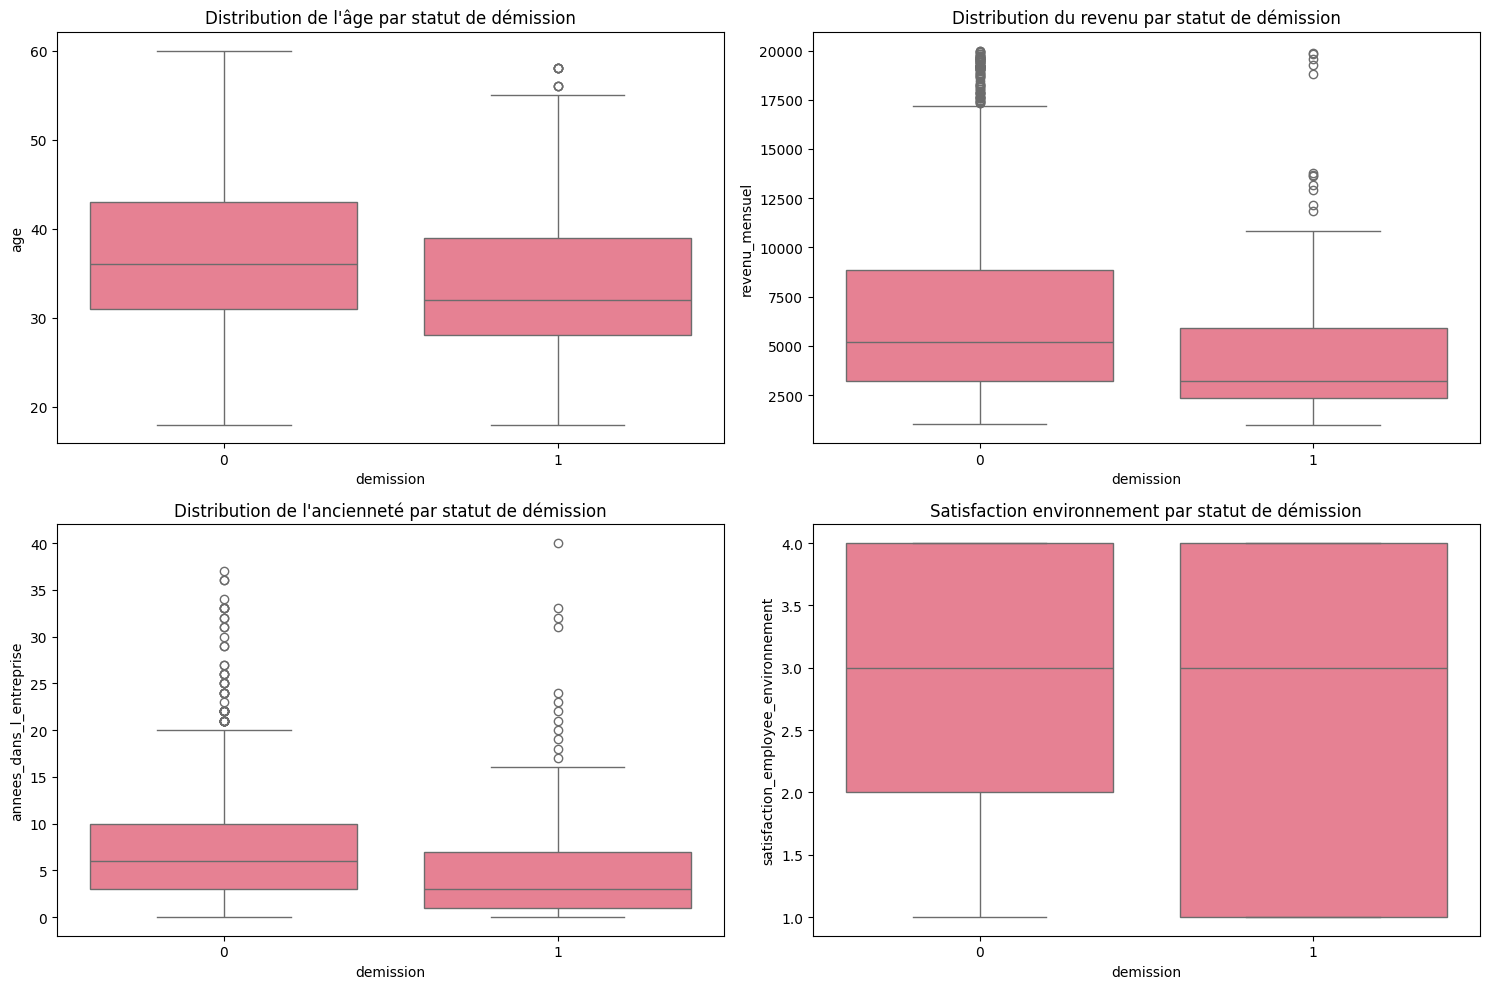

<Figure size 1200x600 with 0 Axes>

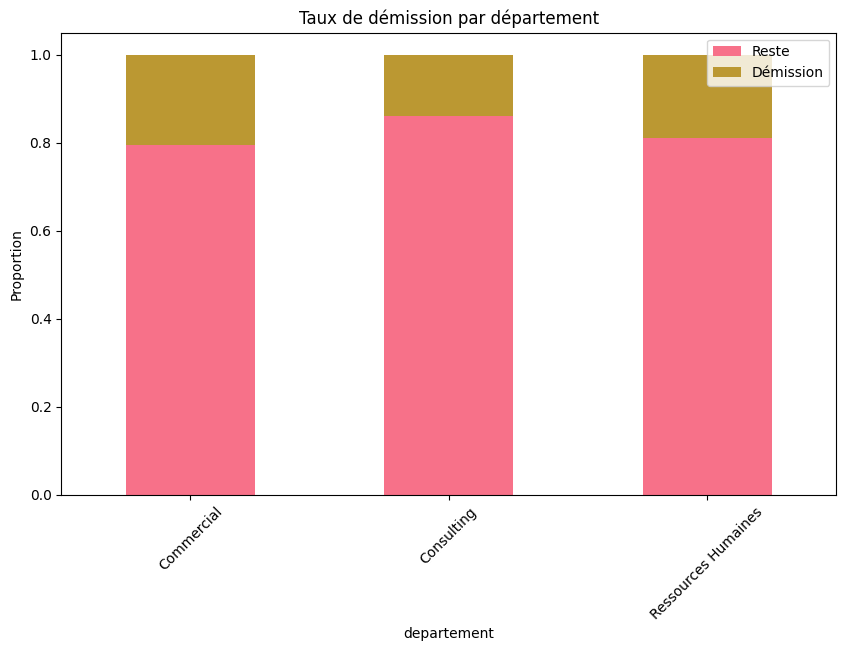

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Age par démission
sns.boxplot(data=df_central, x='demission', y='age', ax=axes[0,0])
axes[0,0].set_title('Distribution de l\'âge par statut de démission')

# Revenu par démission  
sns.boxplot(data=df_central, x='demission', y='revenu_mensuel', ax=axes[0,1])
axes[0,1].set_title('Distribution du revenu par statut de démission')

# Ancienneté par démission
sns.boxplot(data=df_central, x='demission', y='annees_dans_l_entreprise', ax=axes[1,0])
axes[1,0].set_title('Distribution de l\'ancienneté par statut de démission')

# Satisfaction environnement par démission
sns.boxplot(data=df_central, x='demission', y='satisfaction_employee_environnement', ax=axes[1,1])
axes[1,1].set_title('Satisfaction environnement par statut de démission')

plt.tight_layout()
plt.show()

# Graphique additionnel: département par démission
plt.figure(figsize=(12, 6))
crosstab_dept = pd.crosstab(df_central['departement'], df_central['demission'], normalize='index')
crosstab_dept.plot(kind='bar', stacked=True)
plt.title('Taux de démission par département')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(['Reste', 'Démission'])
plt.show()

## 6. Ingénierie de caractéristiques et encodage

In [29]:
def creer_features(df):
    df_features = df.copy()
    
    df_features['ratio_salaire_age'] = df_features['revenu_mensuel'] / df_features['age']
    df_features['anciennete_poste_ratio'] = df_features['annees_dans_le_poste_actuel'] / (df_features['annees_dans_l_entreprise'] + 1)
    
    variables_onehot = ['genre', 'statut_marital', 'departement', 'poste', 'domaine_etude', 'ayant_enfants']
    
    for var in variables_onehot:
        if var in df_features.columns:
            dummies = pd.get_dummies(df_features[var], prefix=var, drop_first=True)
            df_features = pd.concat([df_features, dummies], axis=1)
            df_features.drop(var, axis=1, inplace=True)
    
    variables_label = ['heure_supplementaires', 'frequence_deplacement']
    
    for var in variables_label:
        if var in df_features.columns:
            le = LabelEncoder()
            df_features[var + '_encoded'] = le.fit_transform(df_features[var])
            df_features.drop(var, axis=1, inplace=True)
    
    return df_features

df_features = creer_features(df_central)

colonnes_a_supprimer = ['id_employee', 'eval_number', 'code_sondage', 'a_quitte_l_entreprise']
df_features = df_features.drop(colonnes_a_supprimer, axis=1)

print(f"Dataset avec features: {df_features.shape}")
print(f"Nouvelles colonnes créées: {[col for col in df_features.columns if col not in df_central.columns]}")

Dataset avec features: (1470, 45)
Nouvelles colonnes créées: ['ratio_salaire_age', 'anciennete_poste_ratio', 'genre_M', 'statut_marital_Divorcé(e)', 'statut_marital_Marié(e)', 'departement_Consulting', 'departement_Ressources Humaines', 'poste_Cadre Commercial', 'poste_Consultant', 'poste_Directeur Technique', 'poste_Manager', 'poste_Représentant Commercial', 'poste_Ressources Humaines', 'poste_Senior Manager', 'poste_Tech Lead', 'domaine_etude_Entrepreunariat', 'domaine_etude_Infra & Cloud', 'domaine_etude_Marketing', 'domaine_etude_Ressources Humaines', 'domaine_etude_Transformation Digitale', 'heure_supplementaires_encoded', 'frequence_deplacement_encoded']


## 7. Analyse de corrélation et sélection de features

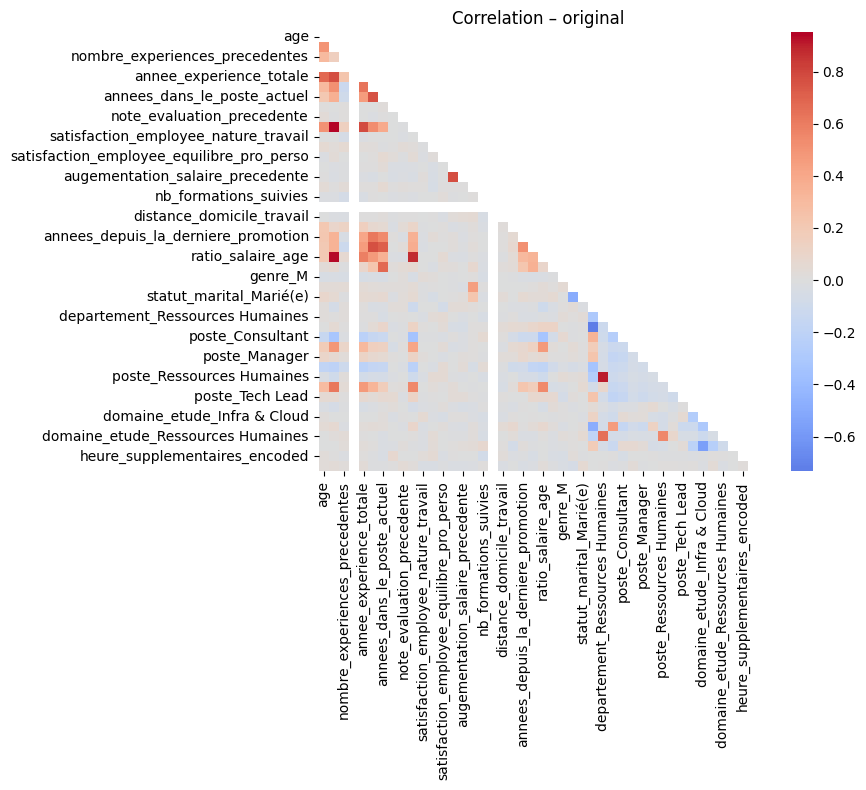

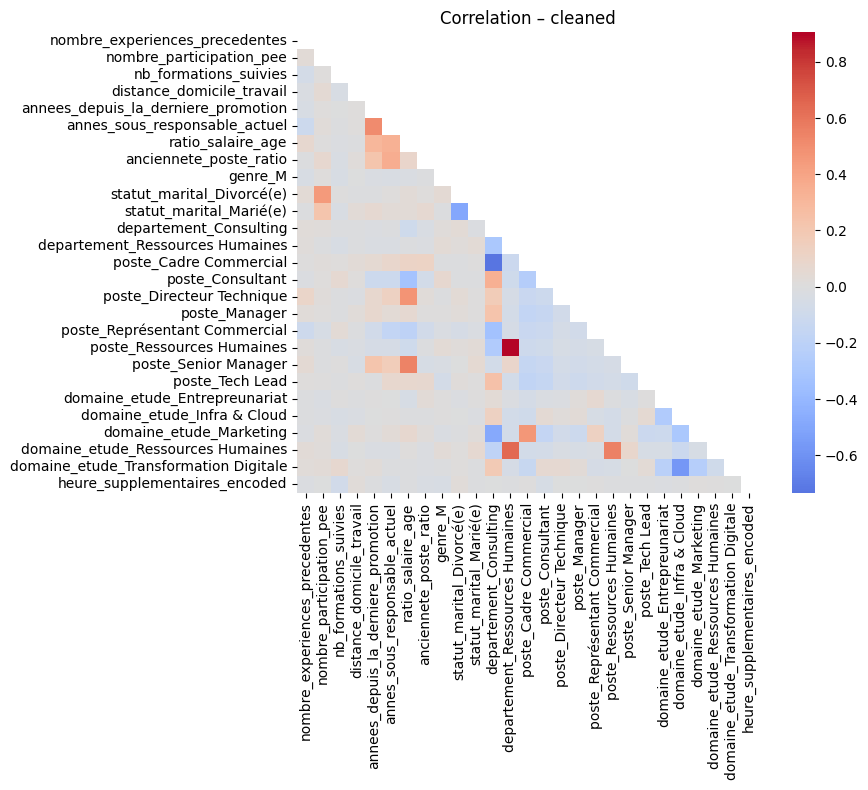

In [30]:
def plot_heatmap(X: pd.DataFrame, *, title: str) -> None:
    corr = X.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, square=True, annot=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(
    df_features.drop(columns="demission"),
    title="Correlation – original",
)

cols_to_remove = [
    'note_evaluation_actuelle',
    'niveau_hierarchique_poste',
    'age',
    'annees_dans_le_poste_actuel',
    'augementation_salaire_precedente',
    'satisfaction_employee_equilibre_pro_perso',
    'note_evaluation_precedente',
    'annees_dans_l_entreprise',
    'niveau_education',
    'annee_experience_totale',
    'satisfaction_employee_equipe',
    'satisfaction_employee_environnement',
    'frequence_deplacement_encoded',
    'satisfaction_employee_nature_travail',
    'revenu_mensuel',
    'nombre_heures_travailless',
    'nombre_employee_sous_responsabilite'
]

df_final = df_features.drop(columns=cols_to_remove)

plot_heatmap(
    df_final.drop(columns="demission"),
    title="Correlation – cleaned",
)

=== CORRELATIONS SPEARMAN ===


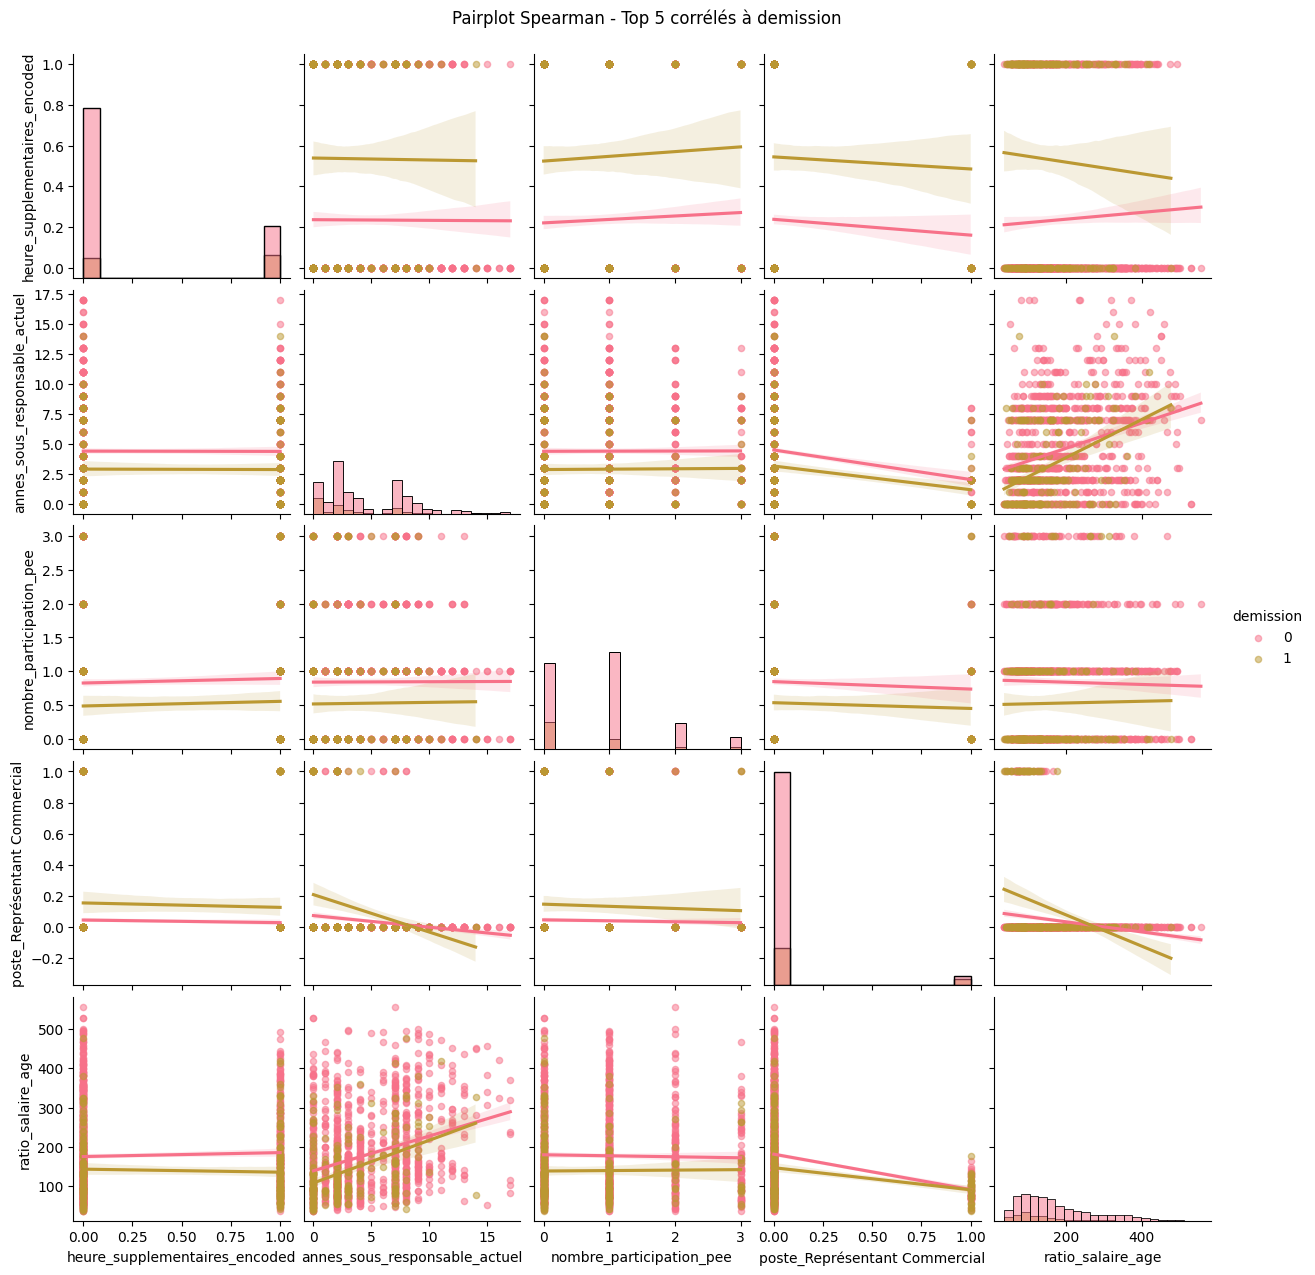

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# 1. Corrélations Spearman entre features numériques
print("=== CORRELATIONS SPEARMAN ===")
features_numeriques = df_final.select_dtypes(include=[np.number]).drop('demission', axis=1)
spearman_corr_matrix = features_numeriques.corr(method='spearman')

# 2. Corrélation de chaque variable avec la cible
target_corr = df_final.corr(method='spearman')['demission'].drop('demission')

# 3. Sélection des N variables les plus corrélées avec la cible
top_features = target_corr.abs().sort_values(ascending=False).head(5).index.tolist()

# 4. Colonnes à inclure dans le pairplot
cols_for_pairplot = top_features + ['demission']

# 5. Génération du pairplot (avec régression et histogrammes)
if len(cols_for_pairplot) > 1:
    sns.pairplot(
        df_final[cols_for_pairplot],
        hue='demission',
        kind='reg',
        diag_kind='hist',    
        plot_kws={'scatter_kws': {'alpha': 0.5, 's': 20}},
    )
    plt.suptitle(f'Pairplot Spearman - Top 5 corrélés à demission', y=1.02)
    plt.show()

## 8. Division et normalisation des données

In [32]:
# Préparation des données finales pour la modélisation
X = df_final.drop('demission', axis=1)
y = df_final['demission']

print(f"=== PREPARATION DES DONNEES ===")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"Taux de démission: {y.mean():.2%}")

# Division train/test avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\n=== REPARTITION TRAIN/TEST ===")
print(f"Train: {X_train.shape[0]} échantillons")
print(f"Test: {X_test.shape[0]} échantillons")
print(f"Taux démission train: {y_train.mean():.2%}")
print(f"Taux démission test: {y_test.mean():.2%}")

# Normalisation des features numériques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Conversion en DataFrame pour garder les noms de colonnes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"\nDonnées normalisées avec StandardScaler")

=== PREPARATION DES DONNEES ===
Features (X): (1470, 27)
Target (y): (1470,)
Taux de démission: 16.12%

=== REPARTITION TRAIN/TEST ===
Train: 1176 échantillons
Test: 294 échantillons
Taux démission train: 16.16%
Taux démission test: 15.99%

Données normalisées avec StandardScaler


## 9. Entraînement de modèles multiples

=== RÉGRESSION LOGISTIQUE ===
TRAIN:
              precision    recall  f1-score   support

           0       0.93      0.74      0.83       986
           1       0.35      0.73      0.48       190

    accuracy                           0.74      1176
   macro avg       0.64      0.74      0.65      1176
weighted avg       0.84      0.74      0.77      1176

TEST:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       247
           1       0.35      0.70      0.47        47

    accuracy                           0.74       294
   macro avg       0.64      0.73      0.65       294
weighted avg       0.84      0.74      0.77       294

--------------------------------------------------
=== LINEAR SVC ===
TRAIN:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       986
           1       0.79      0.19      0.31       190

    accuracy                           0.86      1176
   macro

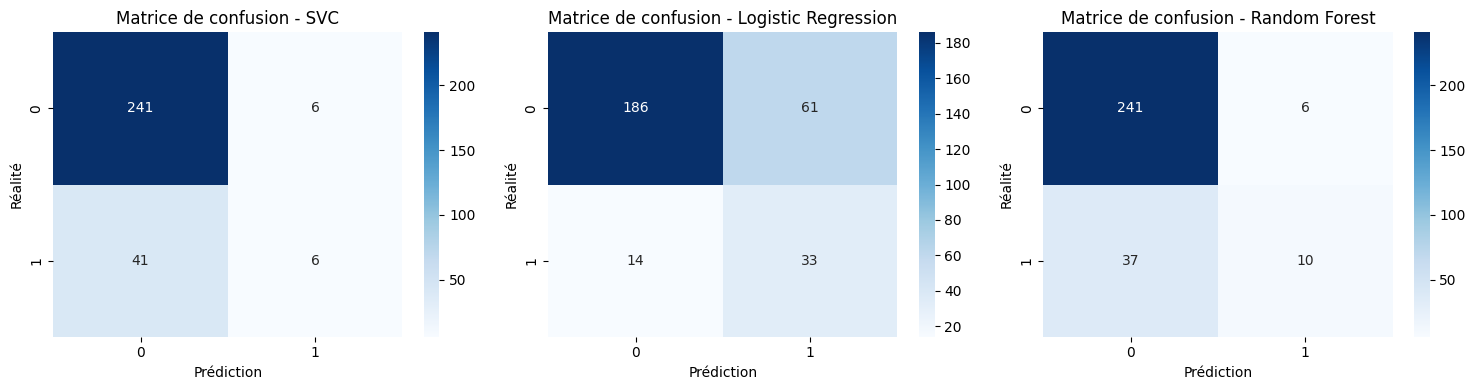

=== COMPARAISON DES MODELES ===
                Modèle  Accuracy  Precision  Recall  F1-Score    AUC
0                  SVC     0.840      0.500   0.128     0.203  0.787
1  Logistic Regression     0.745      0.351   0.702     0.468  0.793
2        Random Forest     0.854      0.625   0.213     0.317  0.730


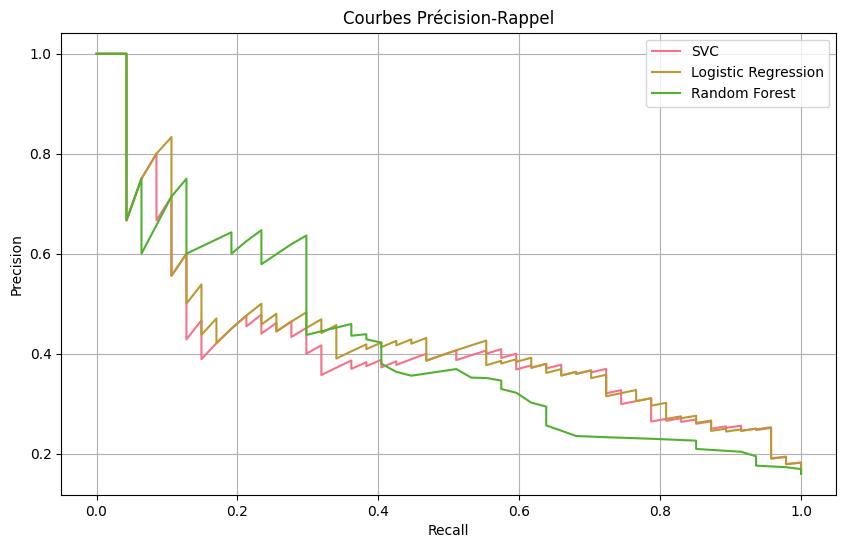

In [33]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# === 1. Balanced Models ===
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
svc_base = LinearSVC(random_state=42, max_iter=1000, class_weight='balanced')
svc_model = CalibratedClassifierCV(svc_base)  # To get predict_proba()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# === 2. Training and Evaluation Function ===
def evaluer_modele(model, X_train, X_test, y_train, y_test, nom_modele):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print(f"=== {nom_modele.upper()} ===")
    print("TRAIN:")
    print(classification_report(y_train, y_train_pred))
    print("TEST:")
    print(classification_report(y_test, y_test_pred))
    print("-" * 50)
    return model

# Fit models
lr_model = evaluer_modele(lr_model, X_train_scaled, X_test_scaled, y_train, y_test, "Régression Logistique")
svc_model = evaluer_modele(svc_model, X_train_scaled, X_test_scaled, y_train, y_test, "Linear SVC")
rf_model = evaluer_modele(rf_model, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest")

# === 3. Optimal Thresholding (on RF as example, can be generalized) ===
def seuil_optimal(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    f1_scores = np.nan_to_num(f1_scores)
    optimal_idx = np.argmax(f1_scores)
    return thresholds[optimal_idx], precision[optimal_idx], recall[optimal_idx], f1_scores[optimal_idx]

# Example: Optimal threshold on Random Forest
threshold_rf, p_rf, r_rf, f1_rf = seuil_optimal(rf_model, X_test_scaled, y_test)
y_pred_rf_opt = (rf_model.predict_proba(X_test_scaled)[:, 1] >= threshold_rf).astype(int)

print(f"=== SEUIL OPTIMAL - RANDOM FOREST ===")
print(f"Seuil: {threshold_rf:.3f}, F1: {f1_rf:.3f}, Précision: {p_rf:.3f}, Rappel: {r_rf:.3f}")
print(classification_report(y_test, y_pred_rf_opt))

# === 4. Confusion Matrices ===
modeles = {
    'SVC': svc_model,
    'Logistic Regression': lr_model, 
    'Random Forest': rf_model
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, (nom, model) in enumerate(modeles.items()):
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Matrice de confusion - {nom}')
    axes[i].set_xlabel('Prédiction')
    axes[i].set_ylabel('Réalité')
plt.tight_layout()
plt.show()

# === 5. Global Metric Comparison ===
resultats = []
for nom, model in modeles.items():
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None

    resultats.append({
        'Modèle': nom,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
    })

df_resultats = pd.DataFrame(resultats)
print("=== COMPARAISON DES MODELES ===")
print(df_resultats.round(3))

# === 6. Precision-Recall Curve (Optional) ===
def tracer_pr_curve(model, X_test, y_test, nom):
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label=nom)

plt.figure(figsize=(10, 6))
for nom, model in modeles.items():
    if hasattr(model, 'predict_proba'):
        tracer_pr_curve(model, X_test_scaled, y_test, nom)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbes Précision-Rappel")
plt.legend()
plt.grid(True)
plt.show()

## 10. Optimisation des hyperparamètres

In [34]:
import time

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid,
    scoring='f1',
    n_jobs=-1,
    cv=cv,
    verbose=1
)

print("Lancement de l'optimisation des hyperparamètres...")
start = time.time()
grid_search.fit(X_train_scaled, y_train)
end = time.time()
print(f"\nTemps écoulé (minutes): {(end - start) / 60:.2f}")

print(f"\n=== MEILLEURS HYPERPARAMETRES ===")
print(grid_search.best_params_)
print(f"Meilleur score F1 (CV): {grid_search.best_score_:.3f}")

# Modèle final optimisé
rf_optimized = grid_search.best_estimator_

# Évaluation croisée
cv_scores = cross_val_score(rf_optimized, X_train_scaled, y_train, cv=cv, scoring='f1')
print(f"\n=== VALIDATION CROISÉE (F1-SCORE) ===")
print(f"Scores: {cv_scores}")
print(f"Moyenne: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Test set
y_pred_final = rf_optimized.predict(X_test_scaled)
print(f"\n=== PERFORMANCE FINALE SUR TEST ===")
print(classification_report(y_test, y_pred_final))

Lancement de l'optimisation des hyperparamètres...
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits

Temps écoulé (minutes): 1.51

=== MEILLEURS HYPERPARAMETRES ===
{'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Meilleur score F1 (CV): 0.473

=== VALIDATION CROISÉE (F1-SCORE) ===
Scores: [0.50746269 0.3125     0.47058824 0.56       0.51685393]
Moyenne: 0.473 (+/- 0.171)

=== PERFORMANCE FINALE SUR TEST ===
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       247
           1       0.39      0.40      0.40        47

    accuracy                           0.80       294
   macro avg       0.64      0.64      0.64       294
weighted avg       0.81      0.80      0.80       294




=== SEUIL OPTIMAL (selon F1) ===
Seuil: 0.436
F1 max: 0.459
Précision: 0.403
Rappel: 0.532

=== PERFORMANCE AVEC SEUIL OPTIMAL ===
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       247
           1       0.40      0.53      0.46        47

    accuracy                           0.80       294
   macro avg       0.65      0.69      0.67       294
weighted avg       0.82      0.80      0.81       294



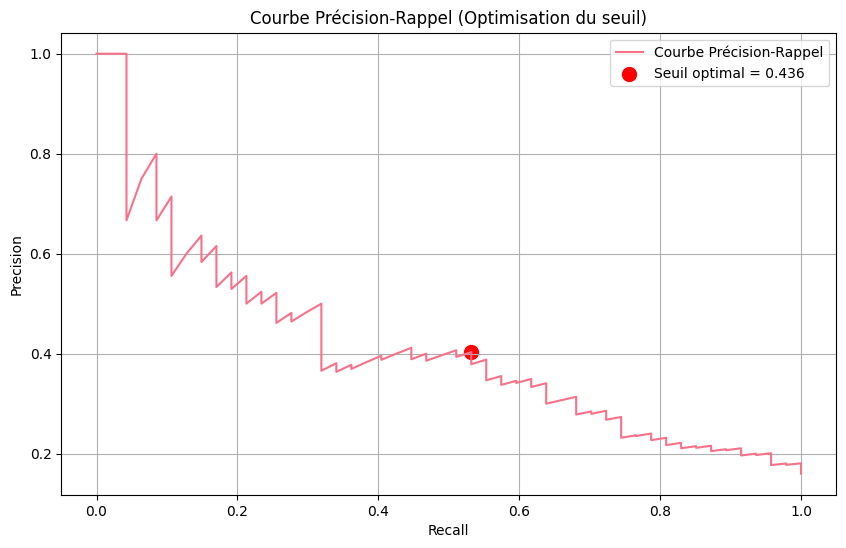

In [35]:
# === THRESHOLD TUNING (based on F1-Score) ===
y_proba = rf_optimized.predict_proba(X_test_scaled)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores)

# Seuil optimal = seuil avec meilleur F1
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\n=== SEUIL OPTIMAL (selon F1) ===")
print(f"Seuil: {optimal_threshold:.3f}")
print(f"F1 max: {f1_scores[optimal_idx]:.3f}")
print(f"Précision: {precision[optimal_idx]:.3f}")
print(f"Rappel: {recall[optimal_idx]:.3f}")

# Prédiction avec seuil optimal
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

print(f"\n=== PERFORMANCE AVEC SEUIL OPTIMAL ===")
print(classification_report(y_test, y_pred_optimal))

# Courbe Précision-Rappel avec seuil
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='Courbe Précision-Rappel')
plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red', s=100,
            label=f'Seuil optimal = {optimal_threshold:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Précision-Rappel (Optimisation du seuil)')
plt.legend()
plt.grid(True)
plt.show()

## 11. Analyse de l'importance des caractéristiques

=== FEATURE IMPORTANCE (RANDOM FOREST) ===
                                feature  importance
6                     ratio_salaire_age    0.124892
5         annes_sous_responsable_actuel    0.108560
7                anciennete_poste_ratio    0.096161
3             distance_domicile_travail    0.089893
26        heure_supplementaires_encoded    0.085756
0        nombre_experiences_precedentes    0.078898
1              nombre_participation_pee    0.078610
4   annees_depuis_la_derniere_promotion    0.050028
2                 nb_formations_suivies    0.038672
14                     poste_Consultant    0.032796

=== PERMUTATION IMPORTANCE ===
                                feature  importance_mean  importance_std
26        heure_supplementaires_encoded         0.023810        0.009740
1              nombre_participation_pee         0.007823        0.007764
11               departement_Consulting         0.004422        0.002657
16                        poste_Manager         0.002041     

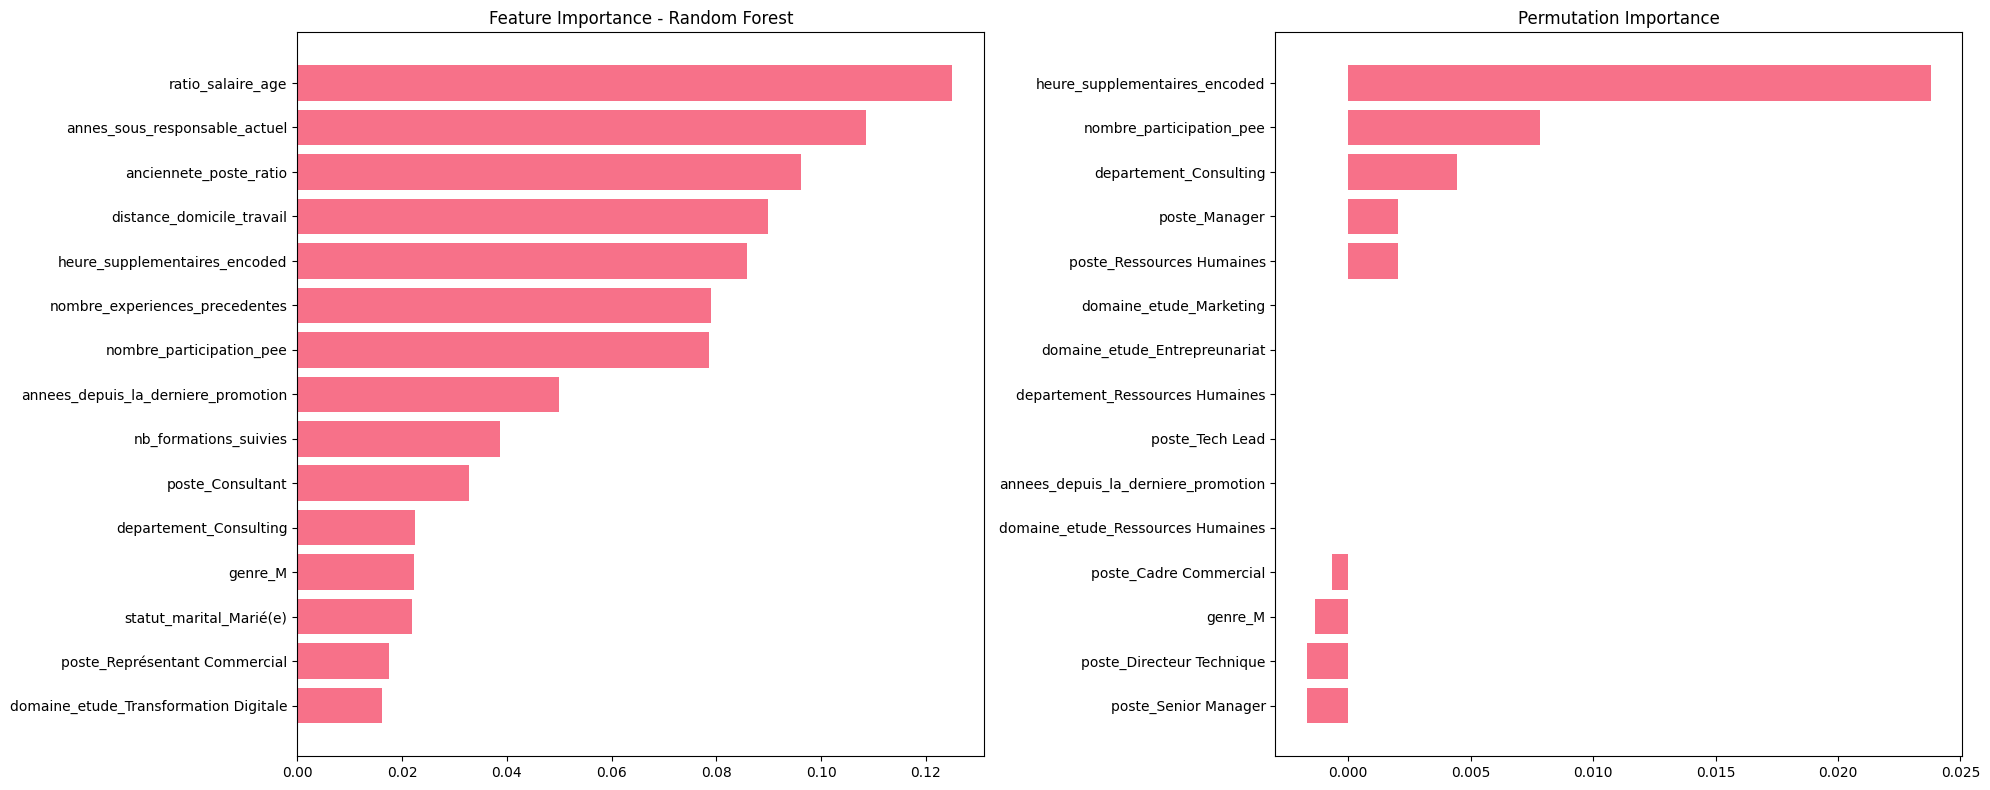


=== FEATURES IMPORTANTES CONVERGENTES ===
Nombre de features convergentes: 3
Features: ['nombre_participation_pee', 'annees_depuis_la_derniere_promotion', 'heure_supplementaires_encoded']


In [36]:
# 1. Feature importance native du Random Forest
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_optimized.feature_importances_
}).sort_values('importance', ascending=False)

print("=== FEATURE IMPORTANCE (RANDOM FOREST) ===")
print(feature_importance_rf.head(10))

# 2. Permutation Importance
perm_importance = permutation_importance(
    rf_optimized, X_test_scaled, y_test, 
    n_repeats=10, random_state=42
)

feature_importance_perm = pd.DataFrame({
    'feature': X_train.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("\n=== PERMUTATION IMPORTANCE ===")
print(feature_importance_perm.head(10))

# Visualisation comparative
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Random Forest importance
top_rf = feature_importance_rf.head(15)
axes[0].barh(range(len(top_rf)), top_rf['importance'])
axes[0].set_yticks(range(len(top_rf)))
axes[0].set_yticklabels(top_rf['feature'])
axes[0].set_title('Feature Importance - Random Forest')
axes[0].invert_yaxis()

# Permutation importance
top_perm = feature_importance_perm.head(15)
axes[1].barh(range(len(top_perm)), top_perm['importance_mean'])
axes[1].set_yticks(range(len(top_perm)))
axes[1].set_yticklabels(top_perm['feature'])
axes[1].set_title('Permutation Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Top features convergentes
top_rf_features = set(feature_importance_rf.head(10)['feature'])
top_perm_features = set(feature_importance_perm.head(10)['feature'])
features_convergentes = top_rf_features.intersection(top_perm_features)

print(f"\n=== FEATURES IMPORTANTES CONVERGENTES ===")
print(f"Nombre de features convergentes: {len(features_convergentes)}")
print(f"Features: {list(features_convergentes)}")

## 12. Analyse SHAP (Shapley Values) - Version simplifiée

=== Calcul SHAP ===
SHAP array shape: (294, 27)
SHAP mean values (non-zero):
nombre_participation_pee                 0.078454
ratio_salaire_age                        0.077119
heure_supplementaires_encoded            0.069535
annes_sous_responsable_actuel            0.067406
poste_Consultant                         0.025643
departement_Consulting                   0.024499
anciennete_poste_ratio                   0.024259
nombre_experiences_precedentes           0.023005
poste_Cadre Commercial                   0.016357
distance_domicile_travail                0.014533
nb_formations_suivies                    0.014132
statut_marital_Divorcé(e)                0.009045
annees_depuis_la_derniere_promotion      0.008918
statut_marital_Marié(e)                  0.006363
poste_Représentant Commercial            0.005848
domaine_etude_Infra & Cloud              0.005468
domaine_etude_Marketing                  0.005380
poste_Directeur Technique                0.004154
domaine_etude_Transform

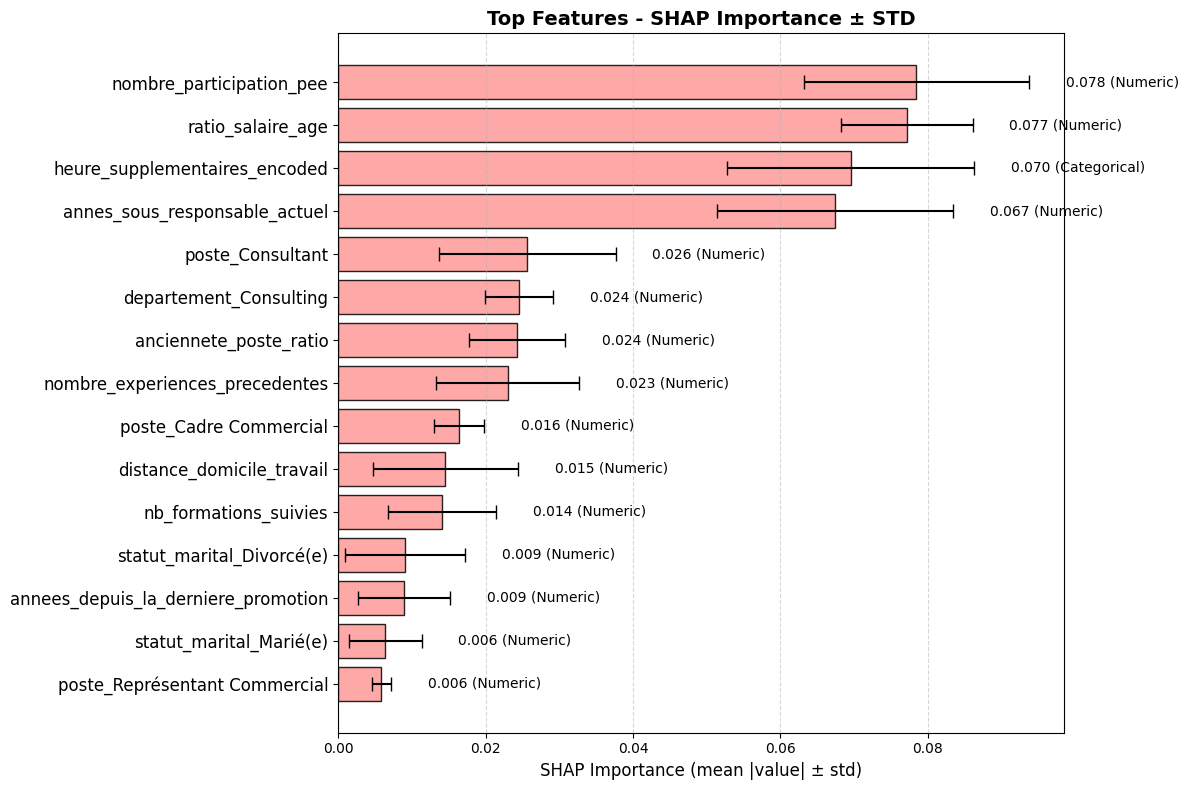

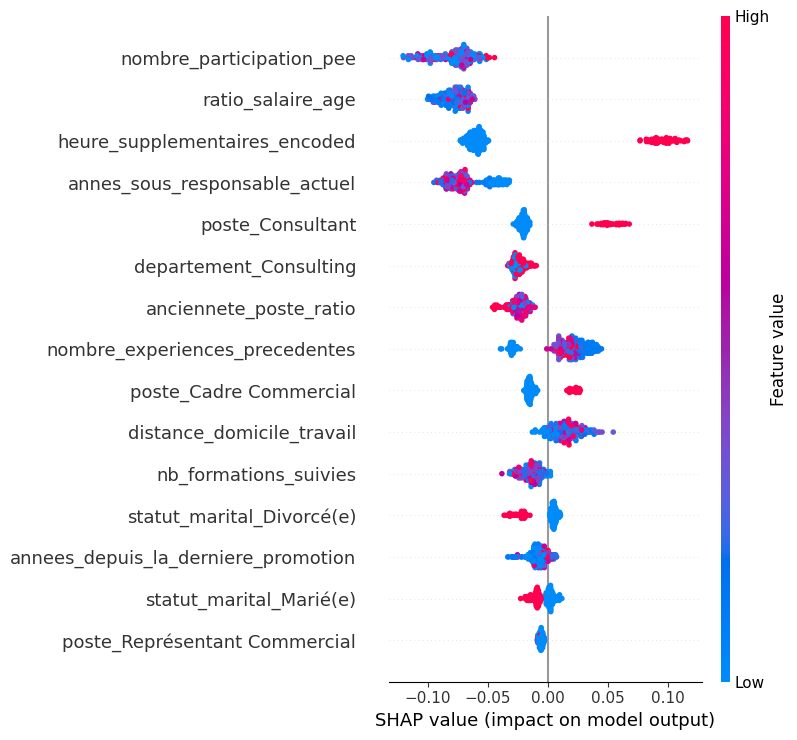


=== TOP FEATURES SELON SHAP ===
                            feature  shap_mean  shap_std  mean_std_ratio feature_type
           nombre_participation_pee   0.078454  0.015321        5.120448      Numeric
                  ratio_salaire_age   0.077119  0.008954        8.611985      Numeric
      heure_supplementaires_encoded   0.069535  0.016741        4.153407  Categorical
      annes_sous_responsable_actuel   0.067406  0.015994        4.214245      Numeric
                   poste_Consultant   0.025643  0.011983        2.139704      Numeric
             departement_Consulting   0.024499  0.004620        5.301142      Numeric
             anciennete_poste_ratio   0.024259  0.006545        3.706170      Numeric
     nombre_experiences_precedentes   0.023005  0.009698        2.371801      Numeric
             poste_Cadre Commercial   0.016357  0.003378        4.841116      Numeric
          distance_domicile_travail   0.014533  0.009824        1.479140      Numeric
              nb_form

In [37]:
import shap

print("=== Calcul SHAP ===")
sample = X_test
explainer = shap.TreeExplainer(rf_optimized)
shap_values = explainer.shap_values(sample)

if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_positive = shap_values[1]
    expected_value = explainer.expected_value[1]
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    shap_values_positive = shap_values[:, :, 1]
    expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 2:
    shap_values_positive = shap_values
    expected_value = explainer.expected_value
else:
    raise ValueError(f"Unexpected SHAP output format: {type(shap_values)}, shape: {np.shape(shap_values)}")

shap_array = np.abs(shap_values_positive)
shap_mean = shap_array.mean(axis=0)
shap_std = shap_array.std(axis=0)
mean_std_ratio = shap_mean / (shap_std + 1e-6)

print(f"SHAP array shape: {shap_array.shape}")
print("SHAP mean values (non-zero):")
print(pd.Series(shap_mean, index=sample.columns)[shap_mean > 0].sort_values(ascending=False))
print(f"Nombre de features avec importance SHAP non-nulle: {np.sum(shap_mean > 0)}")

# Identify feature types (optional)
columns_array = np.asarray(sample.columns)
feature_types = ["Categorical" if "encoded" in col or "_bin" in col else "Numeric" for col in columns_array]

k = min(15, len(shap_mean))
top_k_idx = np.argsort(shap_mean)[-k:][::-1]

top_features = columns_array[top_k_idx]
top_importance = shap_mean[top_k_idx]
top_std = shap_std[top_k_idx]
top_ratio = mean_std_ratio[top_k_idx]
top_types = np.array(feature_types)[top_k_idx]

shap_df = pd.DataFrame({
    "feature": top_features.tolist(),
    "shap_mean": top_importance.tolist(),
    "shap_std": top_std.tolist(),
    "mean_std_ratio": top_ratio.tolist(),
    "feature_type": top_types.tolist()
})

# --- 5. Bar plot: SHAP importance ± std ---
plt.figure(figsize=(12, 8))
ax = plt.gca()

bars = ax.barh(
    y=range(k),
    width=top_importance,
    xerr=top_std,
    align='center',
    color="#FF9999",
    edgecolor='black',
    alpha=0.85,
    capsize=5
)

ax.set_yticks(range(k))
ax.set_yticklabels(top_features, fontsize=12)
ax.invert_yaxis()

ax.set_title("Top Features - SHAP Importance ± STD", fontsize=14, weight='bold')
ax.set_xlabel("SHAP Importance (mean |value| ± std)", fontsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.5)

for i, (v, std, ftype) in enumerate(zip(top_importance, top_std, top_types)):
    ax.text(v + std + 0.005, i, f"{v:.3f} ({ftype})", va='center', fontsize=10)

plt.tight_layout()
plt.show()

shap.summary_plot(shap_values_positive, sample, plot_type="dot", max_display=15, show=True)

print("\n=== TOP FEATURES SELON SHAP ===")
print(shap_df.to_string(index=False))


=== EXEMPLES D'EXPLICATIONS LOCALES (SHAP) ===

Employé à risque élevé (index 168) — probabilité de démission: 39.32%


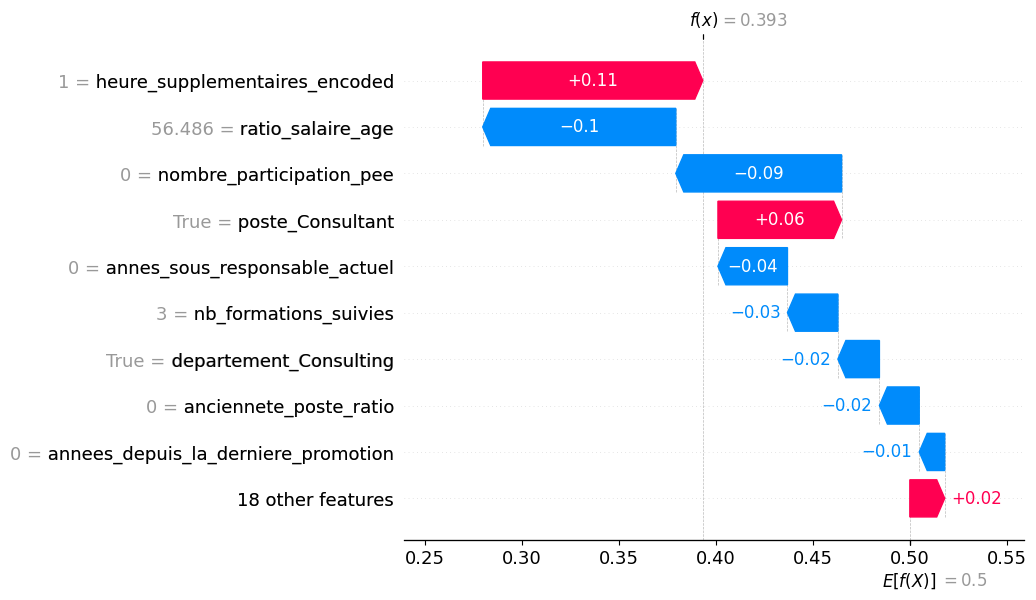


Employé à faible risque (index 165) — probabilité de démission: 4.43%


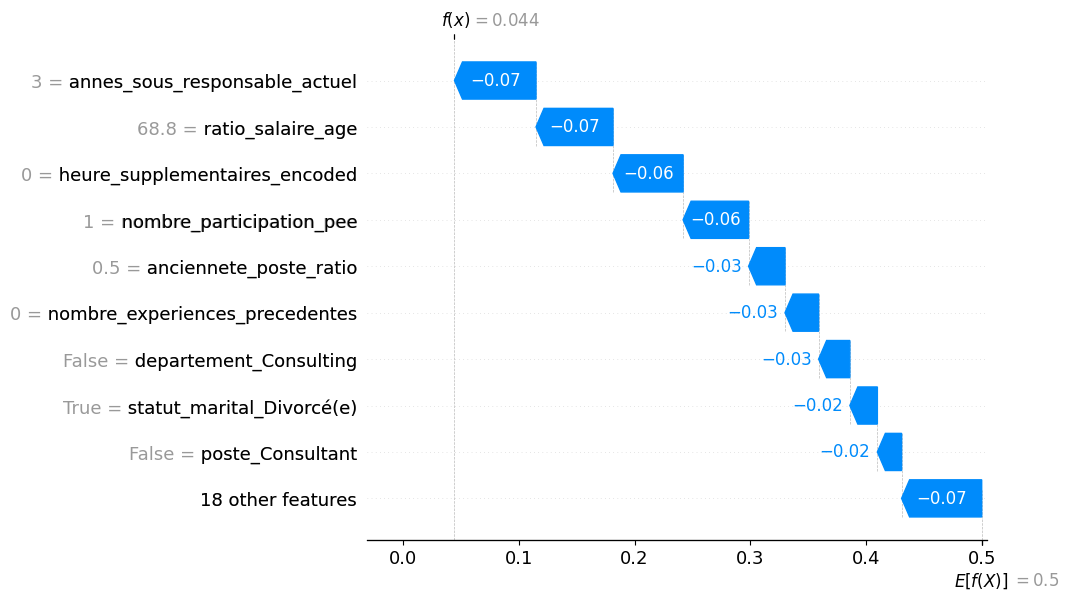

In [38]:
from sklearn.metrics import log_loss

# --- 4. Waterfall Plots simplifiés - Explications locales ---
print("\n=== EXEMPLES D'EXPLICATIONS LOCALES (SHAP) ===")

# Recalculate predicted proba (1 = démission)
proba_pred = rf_optimized.predict_proba(X_test)[:, 1]

# Get one low-risk and one high-risk example
idx_high_risk = np.argmax(proba_pred)
idx_low_risk = np.argmin(proba_pred)

# Extract base value for class 1 if needed
base_value = expected_value[1] if isinstance(expected_value, (list, np.ndarray)) else expected_value

def display_local_explanation(idx, label):
    print(f"\nEmployé {label} (index {idx}) — probabilité de démission: {proba_pred[idx]:.2%}")

    local_df = pd.DataFrame({
        'feature': X_test.columns,
        'value': X_test.iloc[idx].values,
        'shap_value': shap_values_positive[idx]
    }).sort_values('shap_value', key=abs, ascending=False)

    # Waterfall plot using SHAP Explanation object
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values_positive[idx],
            base_values=base_value,
            data=X_test.iloc[idx],
            feature_names=X_test.columns.tolist()
        ),
        max_display=10
    )

# --- Explanation: High resignation probability ---
display_local_explanation(idx_high_risk, label="à risque élevé")

# --- Explanation: Low resignation probability ---
display_local_explanation(idx_low_risk, label="à faible risque")